## Imports

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np
from sklearn.metrics import median_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import itertools

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/Ingrid"

/content/drive/MyDrive/Ingrid


## Lendo Dados

In [ ]:
df= pd.read_csv('data_05_shaft_bearing.csv')

In [ ]:
df= df.dropna()
df=df[df['power']>100]
df= df[df['outdoor_temp']>0]
df= df[df['nacelle']>0]
df= df[df['generator_speed']>0]
df= df[df['gearbox_bearing']>0]
df.drop(columns=["Unnamed: 0"],inplace=True)
print(df)

features = ['generator_speed', 'nacelle']
target = ['gearbox_bearing']
X = df[features]
y = df[target]

PredictorScaler=StandardScaler()
TargetVarScaler=StandardScaler()
PredictorScalerFit=PredictorScaler.fit(X)
TargetVarScalerFit=TargetVarScaler.fit(y)
X=PredictorScalerFit.transform(X)
y=TargetVarScalerFit.transform(y)

                      sample_time      power  outdoor_temp  generator_speed  \
0       2018-01-01 00:00:00+00:00  668.28204     32.369460        973.59010   
1       2018-01-01 00:10:00+00:00  396.09955     32.322247        851.24150   
2       2018-01-01 00:20:00+00:00  337.86740     32.230736        835.06190   
3       2018-01-01 00:30:00+00:00  326.90180     32.051624        830.00200   
4       2018-01-01 00:40:00+00:00  400.90637     31.891493        843.18300   
...                           ...        ...           ...              ...   
157809  2020-12-31 21:30:00+00:00  463.78204     30.680513        886.92694   
157810  2020-12-31 21:40:00+00:00  472.37115     30.551275        884.98804   
157811  2020-12-31 21:50:00+00:00  579.70490     30.431310        939.09460   
157812  2020-12-31 22:00:00+00:00  554.78850     30.328987        927.96220   
157813  2020-12-31 22:10:00+00:00  194.68222     30.234390        352.50555   

          nacelle  gearbox_bearing  
0       39.058

## Construindo o Dataset

In [ ]:
X_train= X[0:100000]
y_train= y[0:100000].reshape((1,len(y[0:100000])))[0]
X_validation = X[10000:105120]
y_validation = y[10000:105120].reshape((1,len(y[10000:105120])))[0]
X_test= X[105120:]
y_test= y[105120:].reshape((1,len(y[105120:])))[0]

## Função Plot Grid

In [ ]:
def Plot_Grid(grid,x,metric,scale_y,namefig):
  sns.set_theme(style="whitegrid")

  plt.rcParams["figure.figsize"] = [scale_y[0], scale_y[1]]
  plt.rcParams["figure.autolayout"] = True

  Grid_List = []

  k_0 = list(grid.keys())[0].split("/")

  del(k_0[-1])

  id_x = ""
  for i in range(len(k_0)):
    if(k_0[i].split(":")[0] == x):
      id_x = i
      break

  combinations = {metric:[],x:[],"hue":[]}

  for key in list(grid.keys()):

    combinations[metric].append(grid[key])

    aux = key.split("/")
    del(aux[-1])

    combinations[x].append(aux[id_x].split(":")[1])

    h = ""
    for j in range(len(aux)):
      if( j!= id_x):
        h += aux[j] + "/"

    combinations["hue"].append(h)



  dataframe = pd.DataFrame(combinations)

  g = sns.catplot(
  data=dataframe, kind="bar",
  x=x, y=metric, hue="hue",
  ci="sd", palette="dark", alpha=.6, height=6
  )
  plt.ylim(scale_y[0], scale_y[1])
  g.despine(left=True)
  g.set_axis_labels(x, metric)
  g.legend.set_title("")
  plt.savefig(namefig + ".png")

## Parâmetros

In [ ]:
grid_name = "Random_4"

n_estimators = [10]
max_depth =  [8]
min_samples_split =  [10]
max_leaf_nodes = [50]
max_features = ["auto","sqrt"]

params = [("n_estimators",n_estimators), ("max_depth",max_depth), ("min_samples_split",min_samples_split),
          ("max_leaf_nodes", max_leaf_nodes),("max_features",max_features)]

In [ ]:
index = 0
Grid = {}
param_legends = []X_train= X[0:100000]
y_train= y[0:100000].reshape((1,len(y[0:100000])))[0]
X_validation = X[10000:105120]
y_validation = y[10000:105120].reshape((1,len(y[10000:105120])))[0]
X_test= X[105120:]
y_test= y[105120:].reshape((1,len(y[105120:])))[0]
all = len(list(itertools.product(n_estimators, max_depth, min_samples_split, max_leaf_nodes)))

for pr in params:
  if(len(pr[1])>1):
    param_legends.append(pr[0])

for (ne, md, mss, mln, mf) in itertools.product(n_estimators, max_depth, min_samples_split, max_leaf_nodes,max_features):

  model = RandomForestRegressor(n_estimators = ne,  max_depth = md, min_samples_split = mss, max_leaf_nodes = mln, n_jobs=8, max_features=mf,verbose=4)
  model.fit(X_train, y_train)

  R2 = model.score(X_test,y_test)
  MSE = mean_squared_error(list(y_test),list(model.predict(X_test)))
  MAE = mean_absolute_error(list(y_test),list(model.predict(X_test)))

  key_string = ""

  for pr_lg in param_legends:

    if(pr_lg == "n_estimators"):
      key_string = key_string + pr_lg + ":" + str(ne) + "/"

    if(pr_lg == "max_depth"):
      key_string = key_string + pr_lg + ":" + str(md) + "/"

    if(pr_lg == "min_samples_split"):
      key_string = key_string + pr_lg + ":" + str(mss) + "/"

    if(pr_lg == "max_leaf_nodes"):
      key_string = key_string + pr_lg + ":" + str(mln) + "/"

    if(pr_lg == "max_features"):
      key_string = key_string + pr_lg + ":" + str(mf) + "/"

  metric = R2
  Grid[key_string] = metric

  percent_process = round(index/all,2)

  if(index % 10 == 0):
    joblib.dump(Grid, grid_name + "_" + "process_" + str(percent_process)+ ".pkl")

  index = index + 1


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=8)]: Done   4 out of  10 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10building tree 4 of 10
building tree 5 of 10

building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s

## Plot Grid

In [ ]:
Grid

{'max_features:auto/': 0.4454884995488221,
 'max_features:sqrt/': 0.44320785264431417}

In [ ]:
#Grid_Load = joblib.load("teste_1_process_0.0.pkl")

No handles with labels found to put in legend.


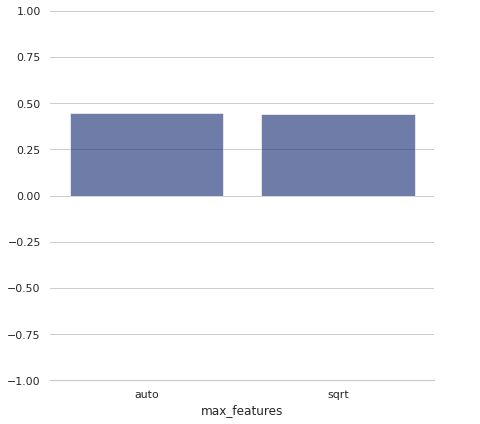

In [ ]:
Plot_Grid(Grid,"max_features","",(-1,1),grid_name)